# Dectecção de Diabetes - Modelos de Classificação

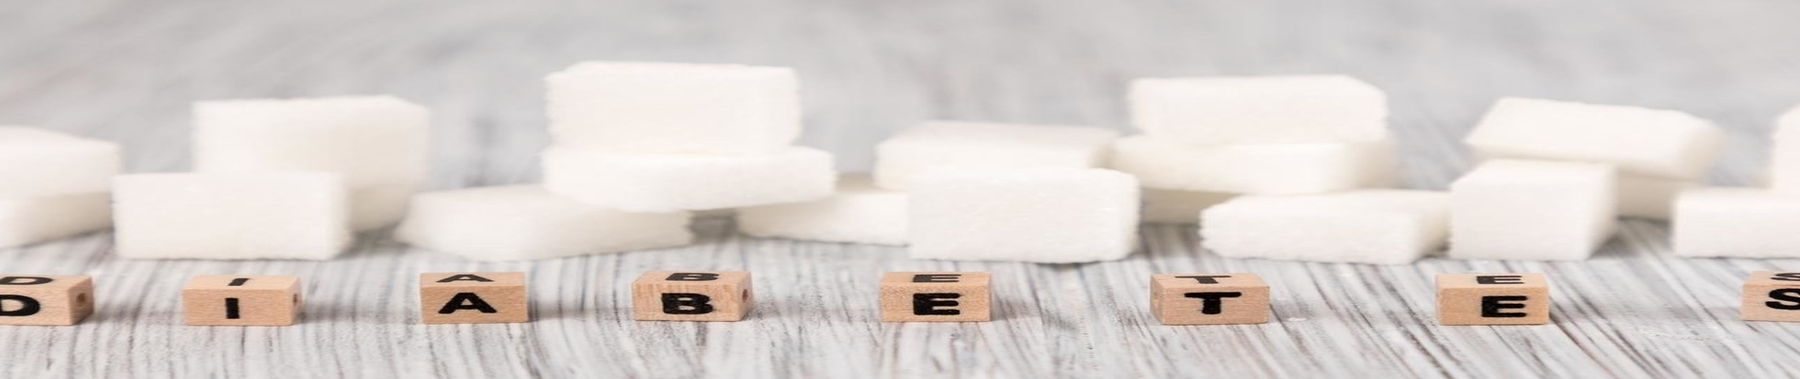

[Fonte da Imagem](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)

## Importar Libs necessárias

* **math**: Fornece funções matemáticas para operações numéricas.

* **joblib**: Usada para salvar e carregar objetos Python em disco.

* **warnings**: Controlar como os avisos são tratadas durante a execução do código.

* **numpy**: Fornece métodos para manipulações de matrizez multidimensionais de maneira eficiente.

* **pandas**: Permite a realização de operações complexas em conjuntos de dados através de DataFrames.

* **seaborn**: Permite a criação de visualizações gráficas 2D com muitos recursos avançados.

* **SVC**: Usada para criar modelos de classificação usando o algoritmo SVM.

* **matplotlib**: Usado para criar gráficos e visualização de dados simples.

* **Pipeline**: útil para organizar e automatizar fluxos de trabalho de pré-processamento e modelagem.

* **ColumnTransformer**: Usada para aplicar transformações específicas em diferentes colunas do conjunto de dados.

* **DecisionTreeClassifier**: Usada para criar modelos de classificação usando árvores de decisão.

* **ConvergenceWarning**: Tipo de aviso emitido quando o algoritmo não consegue convergir durante o treinamento.

* **LogisticRegression**: Usada para criar modelos de regressão logística para problemas de classificação binária.

* **RandomForestClassifier**: Usada para criar modelos de classificação usando o algoritmo Random Forest, que é uma combinação de várias árvores de decisão.

* **StandardScaler**: Usado para padronizar as variáveis (média zero e desvio padrão um)

* **OneHotEncoder**: Usado para transformar variáveis categóricas em codificação one-hot.

* **train_test_split**: Usada para dividir o conjunto de dados em conjuntos de treinamento e teste.

* **GridSearchCV**: Usado para realizar para encontrar os melhores hiperparâmetros de um modelo.

* **accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score**: Várias métricas de avaliação de modelos de aprendizado de máquina.

In [17]:
import math
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

# Evitar que avisos de não convergência poluam o fluxo normal do programa.
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# Permite que as visualizações do Matplotlib sejam exibidas diretamente no output das células do notebook
%matplotlib inline

random_state = 0

## Carregar o conjunto de dados

Neste conjunto de dados, temos informações diagnósticas de pacientes que passaram por testes para detectar diabetes. A última coluna, **Diabetic**, será a variável resposta do nosso modelo e contém o valor 0 para pacientes com resultado negativo e 1 para pacientes com resultado positivo de diabetes.

As outras colunas (Pregnancies,	PlasmaGlucose,	DiastolicBloodPressure,	TricepsThickness,	SerumInsulin,	BMI,	DiabetesPedigree e Age) representam as características que usaremos para fazer a previsão.

[Para mais detalhes do dataset clique aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)

In [3]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


## Separar variáveis preditoras da resposta

Vamos chamar o conjunto de variáveis preditoras, aquelas com as característas que serão utilizadas para previsão do modelo de X e o conjunto com a resposta, a saída do modelo, de y para facilitar a manipulação dos dados durante o treinamento do modelo

In [12]:
resposta    = 'Diabetic'
preditoras  = diabetes.columns.drop([resposta, 'PatientID'])
X, y        = diabetes[preditoras].values, diabetes[resposta].values

# Exibir exemplo da separação
for n in range(0, 5):
    print(f"Paciente {n+1}\n Preditoras: {list(X[n])} \n Resposta: {y[n]}")

Paciente 1
 Preditoras: [0.0, 171.0, 80.0, 34.0, 23.0, 43.50972593, 1.213191354, 21.0] 
 Resposta: 0
Paciente 2
 Preditoras: [8.0, 92.0, 93.0, 47.0, 36.0, 21.24057571, 0.158364981, 23.0] 
 Resposta: 0
Paciente 3
 Preditoras: [7.0, 115.0, 47.0, 52.0, 35.0, 41.51152348, 0.079018568, 23.0] 
 Resposta: 0
Paciente 4
 Preditoras: [9.0, 103.0, 78.0, 25.0, 304.0, 29.58219193, 1.282869847, 43.0] 
 Resposta: 1
Paciente 5
 Preditoras: [1.0, 85.0, 59.0, 27.0, 35.0, 42.60453585, 0.549541871, 22.0] 
 Resposta: 0


Agora vamos criar um gráfico de barras para verificar a distribuição dos pacientes com diagnóstico positivo e negativo da presença de diabetes na amostragem estudada.

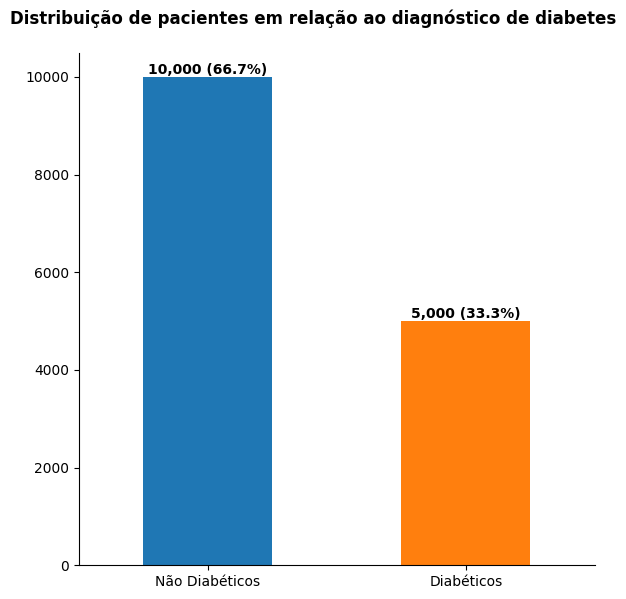

In [13]:
plt.figure(figsize = (6, 6))
plt.xlabel('')
plt.ylabel('')
plt.suptitle("Distribuição de pacientes em relação ao diagnóstico de diabetes", fontweight = 'bold', fontsize = 12, x = 0.0, y = 0.99, ha = 'left')

# Definir valores totais e percentuais
totais       = diabetes['Diabetic'].value_counts()
percentuais  = (totais / len(diabetes)) * 100

# Definir eixo e remover bordas do gráfico
ax = totais.plot(kind = 'bar', color = ['#1f77b4', '#ff7f0e'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adicionar texto acima das barras
for index, value in enumerate(totais):
    plt.text(index, value, f'{totais[index]:,} ({percentuais[index]:.1f}%)', ha = 'center', va = 'bottom', fontweight = 'bold')

# Definições de layout
plt.xticks(ticks = [0, 1], labels = ['Não Diabéticos', 'Diabéticos'], rotation = 0)
plt.tight_layout()
plt.show()

- Existe uma diferença significativa entre os dois grupos, sendo a maioria dos pacientes não diabéticos.

- Agora, vamos comparar as distribuições de cada uma das características em relação a presença ou ausência de diabetes.

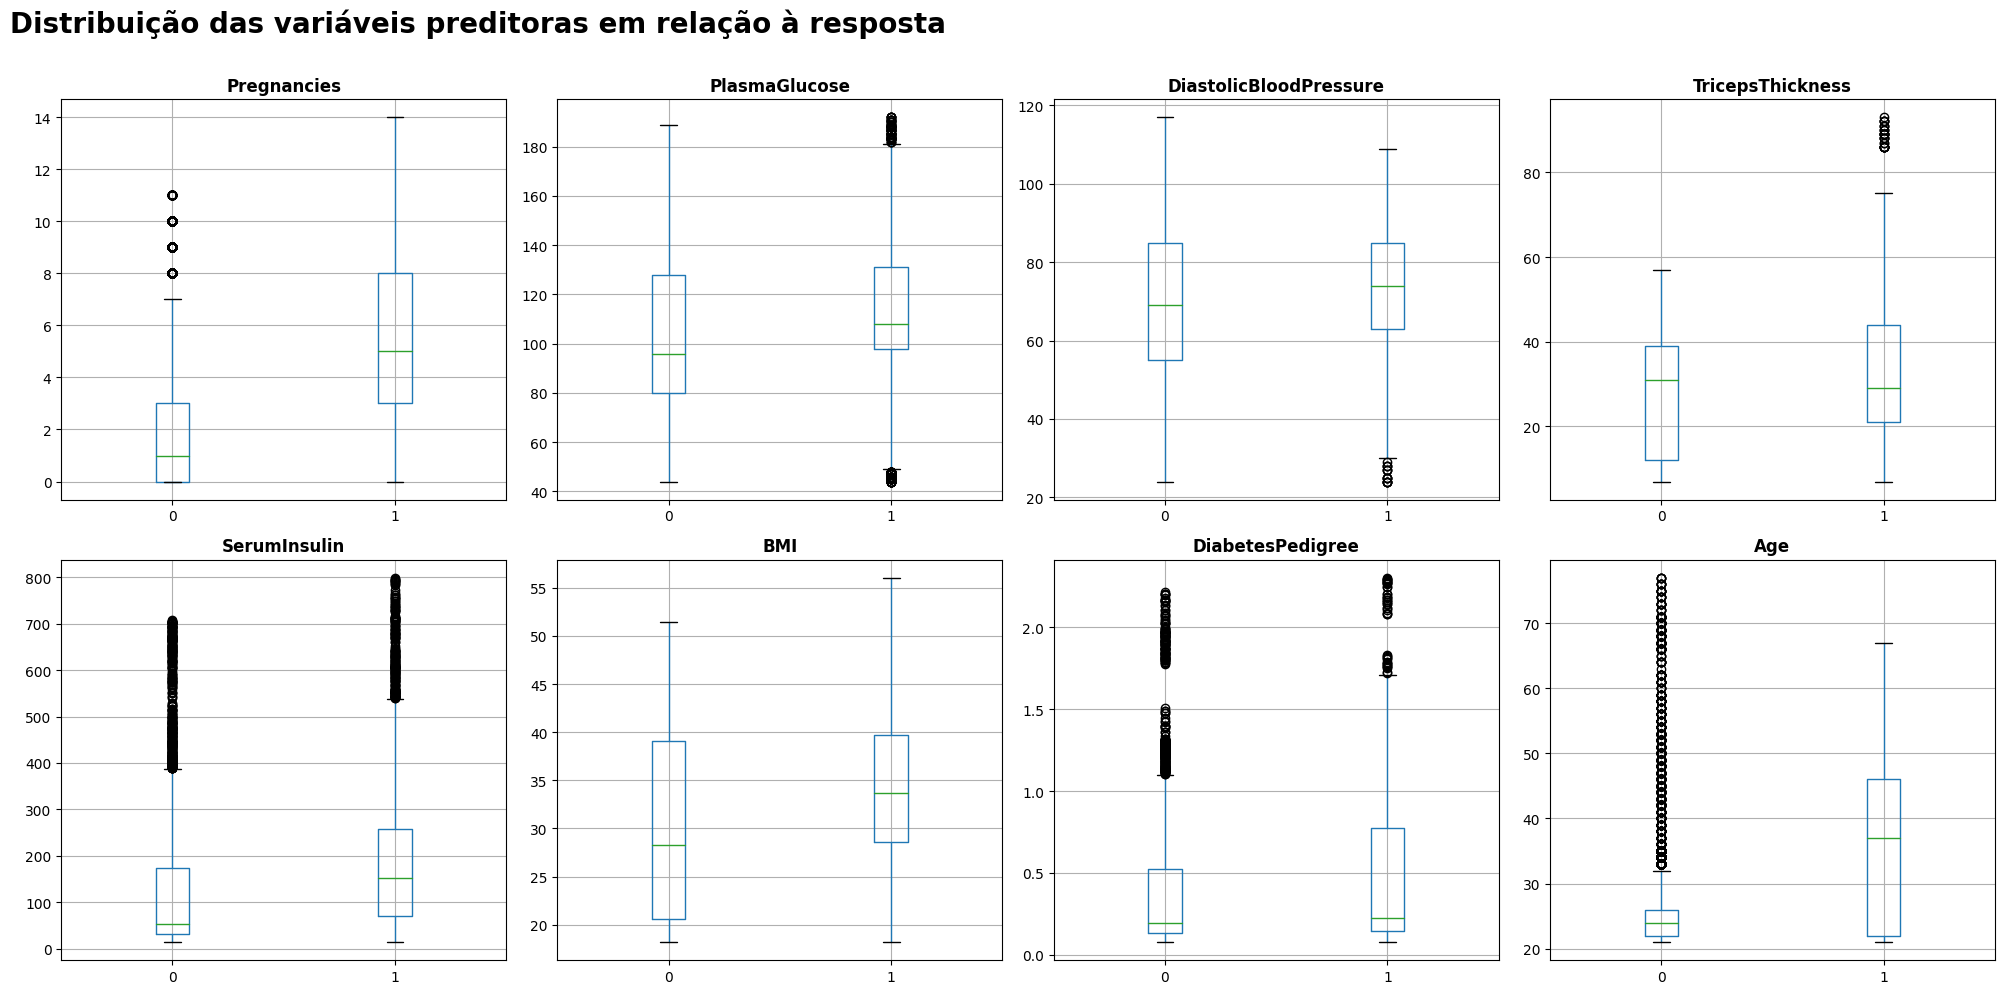

In [14]:
num_linhas  = 2
num_colunas = math.ceil(len(preditoras) / num_linhas)
fig, axes   = plt.subplots(nrows = num_linhas, ncols = num_colunas, figsize = (20, 10))

# Modificando fundo do gráfico
with sns.axes_style("darkgrid"):

  # Plotagem dos boxplots em cada subplot
  for indice, nome_coluna in enumerate(preditoras):
    indice_linha  = indice // num_colunas
    indice_coluna = indice % num_colunas

    diabetes.boxplot(column = nome_coluna, by = resposta, ax = axes[indice_linha, indice_coluna])
    axes[indice_linha, indice_coluna].set_title(nome_coluna, fontweight = 'bold')
    axes[indice_linha, indice_coluna].set_xlabel("")

fig.suptitle("Distribuição das variáveis preditoras em relação à resposta", fontweight = 'bold', fontsize = 20, x = 0.0, y = 0.99, ha = 'left')
fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

Podemos ver nesses casos, em particular para as variáveis **Pregnancies** e **Age** que as distribuições estão extremamente diferentes para pacientes diabéticos em comparação com pacientes não diabéticos. Essas características podem ajudar a prever se um paciente é diabético ou não de forma mais acertiva.

## Separar em conjuntos de treinamento e teste

Por termos conhecimento dos resultados finais de cada teste de diabetes, é possível treinar um classificador para encontrar uma relação estatística entre as características e o valor final do teste.


 Como o conjunto de dados possuí uma quantidade relevante de amostras, podemos usar apenas uma parte dele para treinar o modelo e deixar outra parte para testar o modelo treinado - assim, poderemos comparar os valores previstos com os já conhecidas no conjunto de teste. Nesse caso, vamos dividir os dados em 70% para treinamento e 30% para teste.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = random_state)

print(f' Treinamento: {X_train.shape[0]} - Teste: {X_test.shape[0]}')

 Treinamento: 10500 - Teste: 4500


## Treinar um Modelo de Classificação Binária por Regressão Logística

Existem vários algoritmos que podem ser usados para treinar o modelo. Neste primeiro momento vamos usar a Regressão Logística, um algoritmo bem estabelecido para classificação.

A ideia básica da regressão logística é transformar uma combinação linear de variáveis preditoras em uma probabilidade usando uma função logística (também chamada de função sigmoide).

&nbsp;

1. A combinação linear das variáveis preditoras é calculada:

\begin{equation}
z = \beta_0 + \beta_1 \cdot x_1 + \beta_2 \cdot x_2 + \ldots + \beta_n \cdot x_n
\end{equation}



> Onde:
- z é a combinação linear.
- $\beta_0$ é o coeficiente de intercepção (ou viés).
- $\beta_1, \beta_2, \beta_n$ são os coeficientes associados a cada característica $x_1, x_2, x_n$.
>

&nbsp;

2. Em seguida a função sigmoide é aplicada à combinação linear para obter a probabilidade $P(y=1)$ de pertencer à classe 1:

\begin{equation}
P(y=1) = \frac{1}{1 + e^{-z}}
\end{equation}

&nbsp;

3. E por fim a probabilidade $P(y=0)$ de pertencer à classe 0 é calculada como:

\begin{equation}
P(y=0) = 1 - P(y=1)
\end{equation}

&nbsp;

Além das variáveis preditoras e resposta contidas nos conjuntos de treinamento, vamos definir um parâmetro de regularização. Isso é usado para contrabalançar qualquer viés na amostra e ajudar o modelo a generalizar bem, evitando o ajuste excessivo aos dados de treinamento.

In [21]:
# Definindo uma taxa inicial de regularização
reg    = 0.01
modelo = LogisticRegression(C = 1/reg, solver = "liblinear", random_state = random_state).fit(X_train, y_train)
print(modelo)

LogisticRegression(C=100.0, random_state=0, solver='liblinear')


Agora que treinamos o modelo, vamos usar os dados de teste para avaliar as suas previsões geradas. Vamos primeiro visualizar os primeiros registros da previsão

## Avaliar um Modelo de Classificação Binária

In [22]:
previsoes = modelo.predict(X_test)
print(f'Valores previstos: {previsoes[0:5]}')
print(f'Valores reais: {y_test[0:5]}')

Valores previstos: [0 0 0 1 1]
Valores reais: [0 0 1 1 1]


Como nosso conjunto de testes é muito extenso, tendo 4500 observações, só podemos comparar facilmente alguns valores de forma visual. Vamos então extrair métricas mais relevantes e diretas para avaliar o modelo, sendo a primeira, a acurácia das previsões, ou seja, a proporção das respostas que o modelo previu corretamente.

&nbsp;


\begin{equation}
Accuracy = \frac{True\ Positives + True\ Negatives}{True\ Positives + True\ Negatives + False\ Positives + False\ Negatives}
\end{equation}

In [23]:
print(f'Acurácia: {round(accuracy_score(y_test, previsoes), 2)}')

Acurácia: 0.79


A acurácia é um valor percentual decimal que varia de 0.0 à 1.0. Quanto maiores os valores, maiores os acertos, da mesma forma que valores baixos, representam menos taxas de acertos. Outras métricas importantes que podem ser avaliadas são:

&nbsp;

* **Precision**: Das previsões que o modelo fez para a classe, qual proporção estava correta?

\begin{equation}
Precision = \frac{True\ Positives}{True\ Positives + False\ Positives}
\end{equation}

&nbsp;

* **Recall**: De todas as observações desta classe (verdadeiros positivos e falsos negativos) no conjunto de dados de teste, quantas o modelo identificou corretamente?

\begin{equation}
Recall = \frac{True\ Positives}{True\ Positives + False\ Negatives}
\end{equation}

&nbsp;

* **F1-Score**: Uma métrica média que leva em consideração tanto a precisão quanto o recall.

\begin{equation}
F1-Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}
\end{equation}

&nbsp;

* **Support**: Quantas observações desta classe existem no conjunto de dados de teste?

In [24]:
print(classification_report(y_test, previsoes))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2986
           1       0.72      0.60      0.66      1514

    accuracy                           0.79      4500
   macro avg       0.77      0.74      0.75      4500
weighted avg       0.78      0.79      0.78      4500



Dessas, as métricas mais relevantes a serem destacas, a **precisão (precision)** e **recall** são calculadas com base nesses quatro resultados possíveis das previsões:

* **Verdadeiros Positivos (VP)**: A resposta prevista e a resposta real são ambas iguais a 1.

* **Falsos Positivos (FP)**: A resposta prevista é 1, mas a resposta real é 0.

* **Falsos Negativos (FN)**: A resposta prevista é 0, mas a resposta real é 1.

* **Verdadeiros Negativos (VN)**: A resposta prevista e a resposta real são ambas iguais a 0.

Essas métricas geralmente são exibidas em um formato tabular conhecido como matriz de confusão, que tem a seguinte forma:

\begin{array}{cc|c}
& \text{Valores Verdadiros} & \text{Valores Verdadiros} & \\
& \text{Positivos (1)} & \text{Negativos (0)} \\
\hline
\text{Valores Previstos Positivos (1)} & \text{Verdadeiros Positivos (VP)} & \text{Falsos Positivos (FP)} \\
\text{Valores Previstos Negativos (0)} & \text{Falsos Negativos (FN)} & \text{Verdadeiros Negativos (VN)} \\
\end{array}



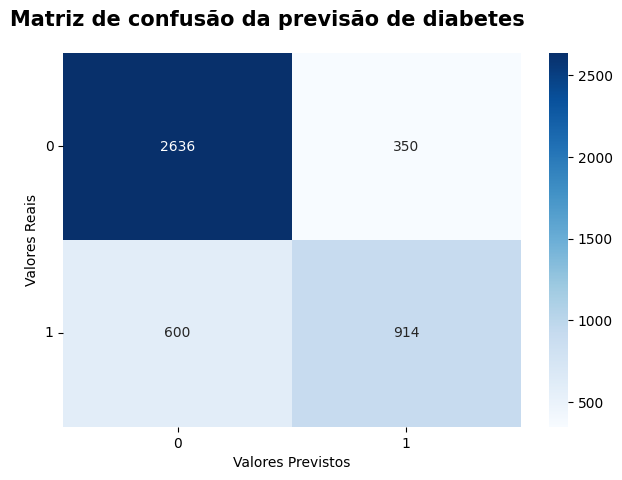

In [25]:
def plotar_matriz_de_confusao(modelo, y_test, X_test):
  previsoes = modelo.predict(X_test)
  cm        = confusion_matrix(y_test, previsoes)

  sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
  plt.suptitle('Matriz de confusão da previsão de diabetes', fontweight = 'bold', fontsize = 15, x = 0.0, y = 0.99, ha = 'left')
  plt.yticks(rotation = 0)
  plt.xlabel('Valores Previstos')
  plt.ylabel('Valores Reais')
  plt.tight_layout()
  plt.subplots_adjust(top = 0.9)
  plt.show()

plotar_matriz_de_confusao(modelo, y_test, X_test)

Até agora, consideramos as previsões do modelo como sendo rótulos de classe 1 ou 0. Porém, na vida real, as coisas são bem mais complexas. Algoritmos, como a regressão logística, são baseados em probabilidadem, sendo o valor previsto na verdade a probabilidade de o rótulo ser verdadeiro (P(y)) e a probabilidade de ser falso (1 - P(y)). Um valor de corte (cutoff) deve ser definido, sendo por padrão na maioria das bibliotecas de 0.5, sendo usado para decidir se o rótulo previsto é um 1 (P(y) > 0.5) ou um 0 (P(y) <= 0.5).

In [26]:
y_scores = modelo.predict_proba(X_test)
print(y_scores[0:5])

[[0.8167346  0.1832654 ]
 [0.96317962 0.03682038]
 [0.80900866 0.19099134]
 [0.24013796 0.75986204]
 [0.33658599 0.66341401]]


A decisão de classificar uma previsão como 1 ou 0 pode variar conforme o cutoff com o qual as probabilidades previstas são comparadas.

Uma maneira de avaliar um classificador é examinar a taxa de **verdadeiros positivos** e a taxa de **falsos positivos** para uma variedade de cutoffs possíveis.

Depois, essas taxas são plotadas em relação a todos os cutoffs possíveis para formar um gráfico conhecido como **Gráfico da Curva Característica de Operação do Receptor (ROC)**.

A **Área Sob a Curva (AUC)** é um valor entre 0 e 1 que quantifica o desempenho geral do modelo. Quanto mais próximo de 1 esse valor estiver, melhor será o modelo.

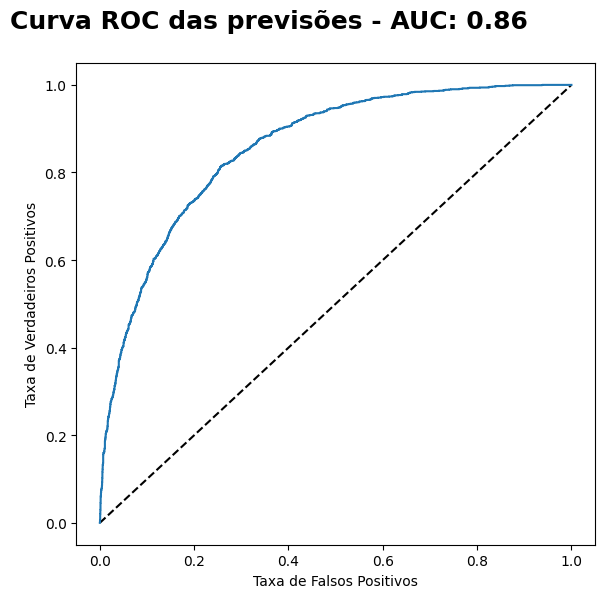

In [27]:
def plotar_curva_roc_auc(modelo, y_test, X_test):
  y_scores             = modelo.predict_proba(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
  auc                  = roc_auc_score(y_test, y_scores[:,1])
  fig                  = plt.figure(figsize = (6, 6))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  fig.suptitle(f'Curva ROC das previsões - AUC: {round(auc, 2)}', fontweight = 'bold', fontsize = 18, x = 0.0, y = 0.99, ha = 'left')
  plt.xlabel('Taxa de Falsos Positivos')
  plt.ylabel('Taxa de Verdadeiros Positivos')
  fig.tight_layout()
  fig.subplots_adjust(top = 0.9)
  fig.show()

plotar_curva_roc_auc(modelo, y_test, X_test)

Nesse caso, a curva ROC e sua AUC indicam que o modelo tem um desempenho superior do que um simples palpite aleatório.

Esse resultado é bem satisfatório considerando não foram realizadas grandes etapas de pré-processamento nos dados.

## Realizar etapas de pré-processamento em um pipeline

No cotidiano de trabalho, é comum e essencial sempre que necessário, realizar etapas de pré-processamento nos dados para facilitar o ajuste de um modelo a eles.

Existem milhares de etapas de pré-processamento possíveis para preparar os dados. Nesse exemplo vamos nos limitar à duas das técnicas mais comuns:

* Dimensionar as características numéricas para que elas fiquem na mesma escala. Isso impede que as características com valores muito grandes produzam coeficientes que afetem desproporcionalmente as previsões.

* Codificar as variáveis categóricas. Por exemplo, usando a técnica de codificação "one-hot", é possível criar características binárias individuais (verdadeiro/falso) para cada valor de categoria possível.


Para aplicar essas transformações de pré-processamento, usaremos um recurso do Scikit-Learn chamado pipelines. Eles nos permitem definir um conjunto de etapas de pré-processamento para um algoritmo.

Isso é útil porque, quando precisarmos usar o modelo para prever valores a partir de novos dados, precisamos aplicar as mesmas transformações.

### Definir o pré-processamento para colunas numéricas (normalizá-las para que estejam na mesma escala)

O StandardScaler do Scikit-Learn é uma das implementações da técnica de normalização e é amplamente utilizada para pré-processar dados numéricos antes de ajustar um modelo.

O pré-processamento envolve:

1. Calcular a média de cada característica;
2. Calcular o desvio padrão de cada característica (**std**);

\begin{equation}
x_{\text{normalized}} = \frac{{x - \text{média}}}{{\text{std}}}
\end{equation}


In [28]:
preditoras_numericas   = [0, 1, 2, 3, 4, 5, 6]
transformador_numerico = Pipeline(steps = [('scaler', StandardScaler())])

### Definir pré-processamento para características categóricas (codificar a coluna '**Age**').

O OneHotEncoder é uma técnica de pré-processamento de dados utilizada em aprendizado de máquina para lidar principalmente com variáveis categóricas. Ele converte cada valor categórico em um vetor binário, onde apenas uma posição é igual a 1 (hot, ou quente) e todas as outras são 0 (cold, ou fria).

* **Exemplo dos dados Originais**:

\begin{array}{ccc}
\text{Caract.1} & \text{Caract.2} & \text{Caract.3} \\
\hline
0 & 1 & 0 \\
1 & 0 & 0 \\
1 & 0 & 1 \\
0 & 1 & 1 \\
2 & 2 & 2 \\
\end{array}

&nbsp;

* **Exemplo dos dados após One-Hot**:

\begin{array}{cccccccc}
\text{Caract.1 = 0} & \text{Caract.1 = 1} & \text{Caract.1 = 2} & \text{Caract.2 = 0} & \text{Caract.2 = 1} & \text{Caract.2 = 2} & \text{Caract.3 = 0} & \text{Caract.3 = 1} & \text{Caract.3 = 2}\\
\hline
1 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & 0 & 0 & 0 & 1 & 0\\
1 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0\\
0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1\\
\end{array}

In [29]:
preditoras_categoricas    = [7]
transformador_categorico  = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

### Combinar etapas de pré-processamento e criar pipeline de treinamento com Grid Search

Agora que as principais definições foram feitas, é possível encapsular todas as etapas de pré-processamento e definições de treinamento do modelo na pipeline.

Porém, antes, podemos melhorar ainda mais as previsões encontrando os melhores conjuntos de **hiperparâmetros**.

Esses são parâmetros **externos** que precisam ser definidos manualmente pelo usuário antes do processo de treinamento, diferentes dos parâmetros **internos**, que são ajustados automaticamente pelo algoritmo durante o processo de treinamento para gerar melhores previsões.

Para ajudar na definição do melhor conjunto de hiperparâmetros é empregada a técnica do **Grid search**.

Seu funcionamento é resumidamente:

1. Definir um conjunto de valores possíveis para cada hiperparâmetro que se deseja otimizar.

2. Treinar e avaliar o modelo para cada combinação de valores desses hiperparâmetros, através de validação cruzada (evitar vieses).

3. Retornar os melhores hiperparâmetros que resultaram no melhor desempenho do modelo com base em uma métrica de avaliação específica, como acurácia ou F1-score.

In [30]:
# Combinar as etapas de pré-processamento
pre_processamento = ColumnTransformer(transformers =
[
    ('num', transformador_numerico,   preditoras_numericas),
    ('cat', transformador_categorico, preditoras_categoricas)
])

# Criar pipeline de treinamento
pipeline = Pipeline(steps =
[
    ('preprocessor', pre_processamento),
    ('log',          LogisticRegression(random_state = random_state))
])

# Definir combinações possíveis de hiperparâmetros
params_grid = {
    'log__C':      [ 0.1, 1.0, 10.0, 100.0 ],
    'log__solver': [ 'liblinear', 'lbfgs', 'sag', 'saga' ]
}

grid_pipeline = GridSearchCV(pipeline, params_grid)

modelo = grid_pipeline.fit(X_train, y_train)
print(grid_pipeline.best_params_)

{'log__C': 100.0, 'log__solver': 'saga'}


Após realizado o treinamento, vamos novamente realizar previsões para o conjunto de teste e comparar as métricas de desempenho com o modelo básico anterior.

### Matriz de Confusão

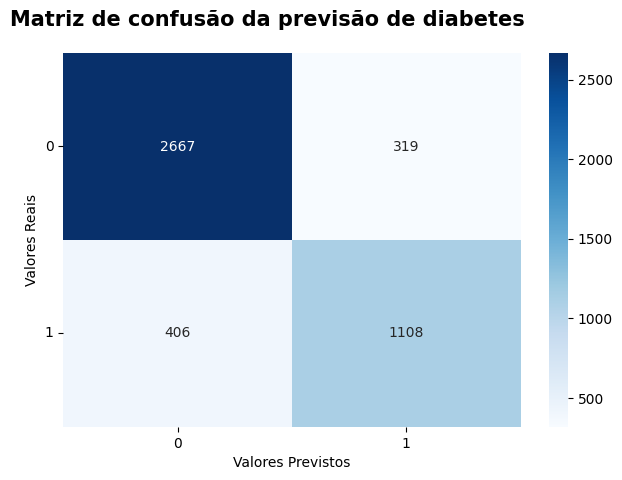

In [31]:
plotar_matriz_de_confusao(modelo, y_test, X_test)

### Curva ROC / AUC

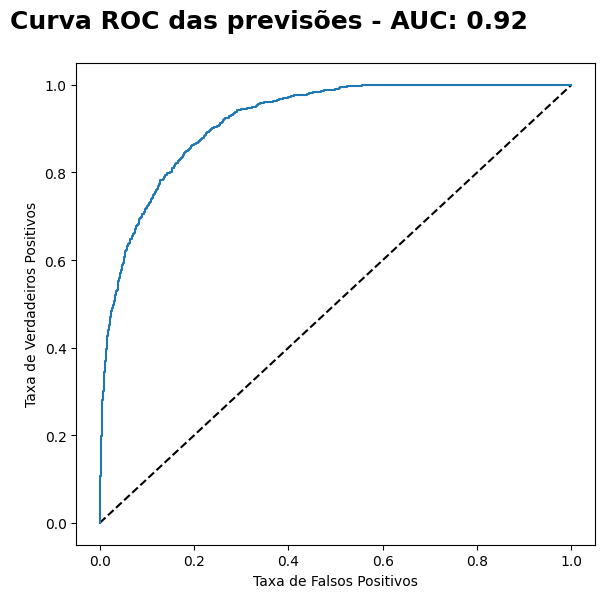

In [32]:
plotar_curva_roc_auc(modelo, y_test, X_test)

Os resultados parecem bem melhores, então claramente o pré-processamento dos dados fez muita diferença no final.

## Testar outros algoritmos de classificação.

Agora vamos tentar um algoritmo diferente. Anteriormente, foi utilizada a regressão logística, um algoritmo linear. Existem muitos tipos de algoritmos de classificação para realização de experimento, como por exemplo:

* **Algoritmos baseados em árvores**: Algoritmos que constroem uma árvore de decisão para chegar a uma previsão.

* **Algoritmos de Máquina de Vetores de Suporte (SVM)**: Algoritmos que definem um hiperplano que separa as classes.

* **Algoritmos de Conjuntos (Ensemble)**: Algoritmos que combinam as saídas de vários algoritmos base para melhorar a generalização.

Vamos utilizar as mesmas etapas de pré-processamento de antes, mas treinaremos o modelo usando um algoritmo de conjuntos chamado **Random Forest** que combina as saídas de várias árvores de decisão aleatórias."

### Decision Tree

A **decision tree (árvore de decisão)** é um modelo de aprendizado de máquina muito utilizado para classificação. Ela é uma representação gráfica e hierárquica de decisões e suas consequências, baseada em características ou atributos de um conjunto de dados.

Seu funcionamento é basicamente:

- O algoritmo busca o atributo que melhor separa os dados com base em algum critério, geralmente uma métrica de ganho de informação como o **índice Gini** ou **entropia**. O atributo escolhido é aquele que melhor separa as classes e reduz a incerteza.

- Após a divisão com base no atributo selecionado, são criados nós na árvore. Cada nó representa uma decisão com base no valor do atributo escolhido.

- O processo de escolha do atributo e divisão do conjunto de dados é repetido então para cada novo nó criado. Isso é feito até que certos critérios de parada sejam atendidos, como a profundidade máxima da árvore.

A maior vantagem da árvore de decisão é a capacidade de interpretar facilmente as decisões tomadas durante o processo de classificação.

In [33]:
pipeline = Pipeline(steps =
[
    ('preprocessor', pre_processamento),
    ('tree',         DecisionTreeClassifier(random_state = random_state))
])

params_grid = {
    'tree__criterion':         [ 'gini', 'entropy' ],
    'tree__max_depth':         [ None, 5, 10, 20 ],
    'tree__min_samples_split': [ 2, 5, 10 ],
    'tree__min_samples_leaf':  [ 1, 2, 4 ]
}

grid_pipeline = GridSearchCV(pipeline, params_grid)

modelo = grid_pipeline.fit(X_train, y_train)
print(grid_pipeline.best_params_)

{'tree__criterion': 'gini', 'tree__max_depth': 10, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 10}


#### Matriz de Confusão

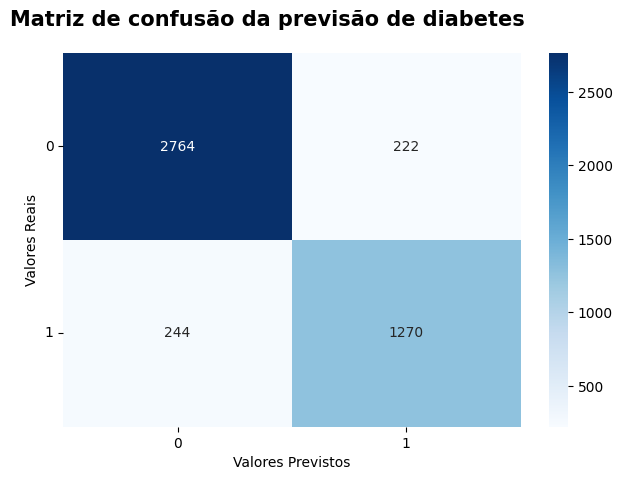

In [34]:
plotar_matriz_de_confusao(modelo, y_test, X_test)

#### Curva ROC / AUC

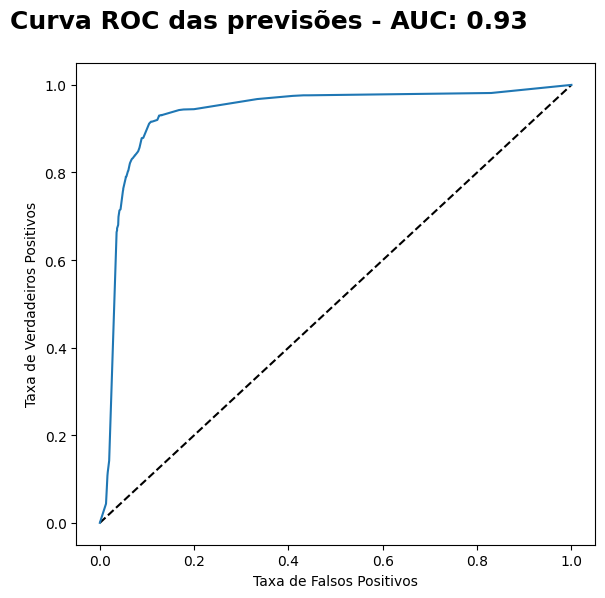

In [35]:
plotar_curva_roc_auc(modelo, y_test, X_test)

### SVM

O objetivo do algoritmo é encontrar uma linha reta que possa separar os pontos que representam cada classe da melhor maneira possível.

Sua principal vantagem é não apenas encontrar uma linha qualquer, mas a "melhor" linha possível. Essa linha é aquela que fica mais longe dos pontos de cada classe.

Os pontos que ficam bem na borda do espaço entre esse grupos de pontos, ou seja, os pontos mais próximos da linha, são chamados de "vetores de suporte". Eles são cruciais para o SVM, pois são eles que realmente definem a posição da linha de separação.

Quando chegam novas previsões, basta olhar de que lado da linha elas estão.

Outra vantagem é poder lidar com dados que não são linearmente separáveis, ou seja, que não podem ser separados por uma única linha reta. Para isso, ele usa uma técnica chamada "kernel", que permite encontrar outras superfícies  mais complexas, como círculos ou curvas, em vez de apenas uma linha reta.

In [44]:
pipeline = Pipeline(steps =
[
    ('preprocessor', pre_processamento),
    ('svm',          SVC(random_state = random_state, probability = True))
])

params_grid = {
    'svm__C':      [ 0.1, 1, 10 ],
    'svm__kernel': [ 'linear', 'rbf' ]
}

grid_pipeline = GridSearchCV(pipeline, params_grid)

modelo = grid_pipeline.fit(X_train, y_train)
print(grid_pipeline.best_params_)

{'svm__C': 10, 'svm__kernel': 'rbf'}


#### Matriz de Confusão

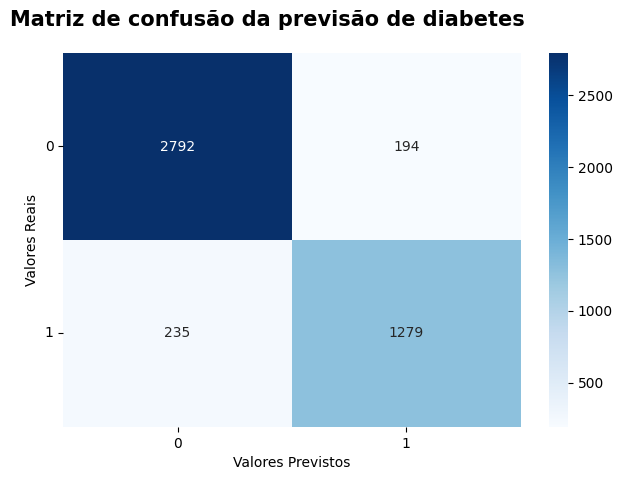

In [45]:
plotar_matriz_de_confusao(modelo, y_test, X_test)

#### Curva ROC / AUC

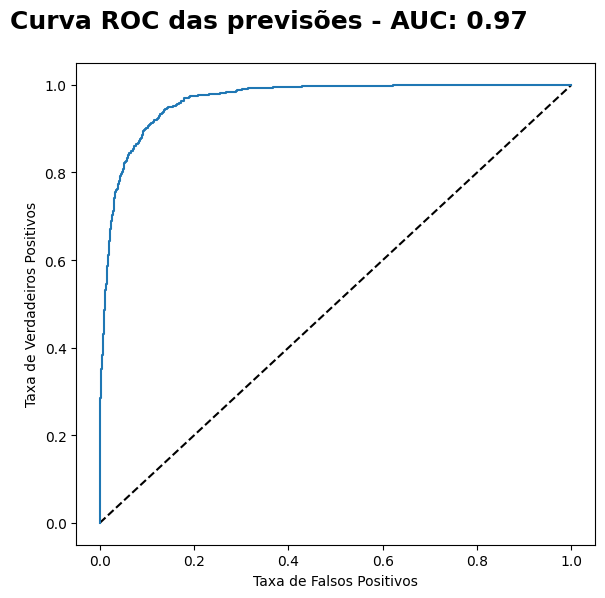

In [46]:
plotar_curva_roc_auc(modelo, y_test, X_test)

### Random Forest

É uma técnica que cria várias árvores de decisão de forma aleatória. Cada árvore é construída com um subconjunto aleatório dos dados de treinamento e apenas algumas das características disponíveis. Esse processo é chamado de "amostragem com reposição" (bootstrap) e "amostragem aleatória de características".

Quando temos uma nova previsão chega para ser classificada, cada árvore do Random Forest toma uma decisão com base em suas próprias regras. Em vez de escolher a classe com base em uma única árvore, o Random Forest faz com que todas as árvores escolham uma classe. A classe mais votada se torna a previsão final do Random Forest.

A principal vantagem é que, ao combinar várias árvores, o risco de overfitting (quando o modelo se ajusta em excesso aos dados de treinamento e não generaliza bem para novos dados) é reduzido. Além disso, ao usar várias árvores, o algoritmo pode lidar com conjuntos de dados complexos, capturando relacionamentos não lineares e interações entre características.

In [47]:
pipeline = Pipeline(steps =
[
    ('preprocessor', pre_processamento),
    ('rf',           RandomForestClassifier(random_state = random_state))
])

params_grid = {
  'rf__n_estimators':      [ 1, 10, 100 ],
  'rf__min_samples_split': [ 2, 3, 4, 5 ]
}

grid_pipeline = GridSearchCV(pipeline, params_grid)

modelo = grid_pipeline.fit(X_train, y_train)
print(grid_pipeline.best_params_)

{'rf__min_samples_split': 3, 'rf__n_estimators': 100}


#### Matriz de Confusão

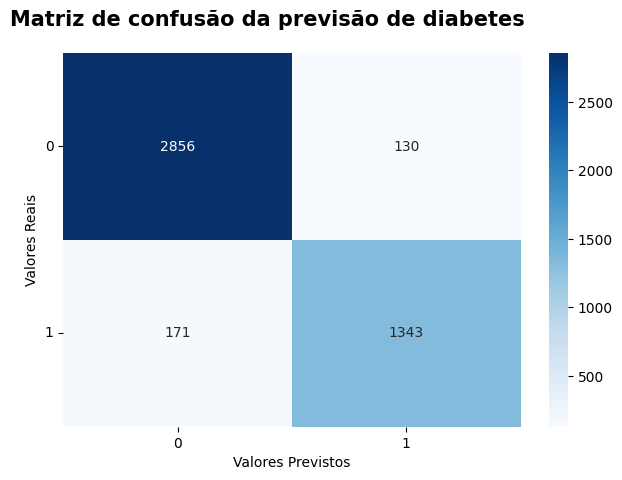

In [48]:
plotar_matriz_de_confusao(modelo, y_test, X_test)

#### Curva ROC / AUC

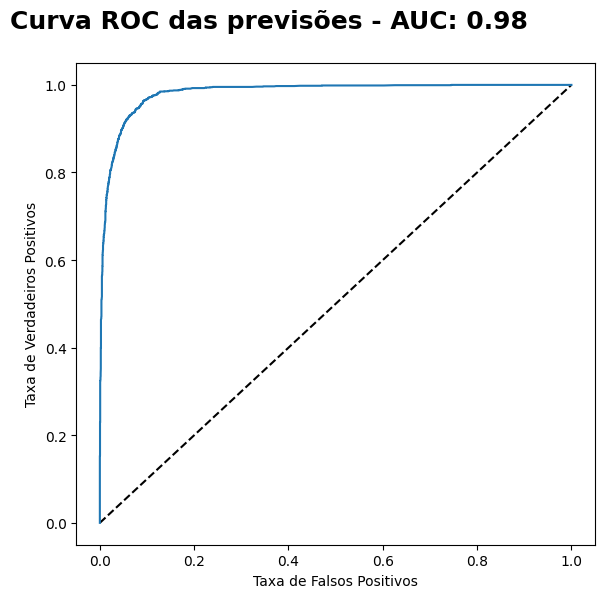

In [49]:
plotar_curva_roc_auc(modelo, y_test, X_test)

Parece que enfim chegamos num dos melhores possíveis resultados.

## Utilizando o modelo para futuras previsões

Agora que temos um modelo treinado bem aderente, podemos salvar ele para uso em previsões futuras. Para isso vamos usar a biblioteca **joblib** para realizar a serialização, (processo de converter objetos em uma sequência de bytes para que possam ser armazenados em um arquivo ou transmitidos pela rede) nesse casao, do modelo de aprendizado de máquina nOo formato **.pkl**, que é amplamente usado para armazenar objetos Python, pois é independente de plataforma e pode ser facilmente lido e carregado de volta em qualquer plataforma que suporte Python.

In [50]:
arquivo_modelo = './diabetes_model.pkl'
joblib.dump(modelo, arquivo_modelo)

['./diabetes_model.pkl']

Quando houver a necessidade de realizar previsões para novas observações onde a resposta é desconhecida, podemos carregar o modelo e usá-lo.

In [51]:
# Carregar o modelo direto do arquivo
modelo = joblib.load(arquivo_modelo)

# O modelo aceita uma matriz geral onde, cada índice representa o conjunto de variáveis
# preditoras de uma observação (outra matriz), como no exemplo abaixo, onde vamos simular
# a previsão de somente um paciente
X_novo = np.array([[ 2, 180, 74, 24, 21, 23.9091702, 1.488172308, 22 ]])

# Realizar a previsão
previsao = modelo.predict(X_novo)

# O modelo retorna uma matriz de previsões, uma para cada conjunto de variáveis preditoras enviado.
# Nesse caso, como enviamos apenas um paciente, então nossa previsão é o primeiro índice da matriz.
print(f'Valor previsto é: {previsao[0]}')

Valor previsto é: 1
